In [3]:
from bs4 import BeautifulSoup
import re
import glob
import os
import requests
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from pathlib import Path
import pandas as pd
import glob
from nltk.corpus import stopwords
import altair as alt
import numpy as np

In [4]:
def get_links_and_dates():
    links_txt_path = 'data/links.txt'
    with open(links_txt_path, 'r') as links_txt:
        links = links_txt.readlines()

    dates = []
    for link in links:
        file_date = re.sub('https://www.federalreserve.gov/monetarypolicy/fomcminutes', '', link)
        file_date = re.sub('.htm\n', '', file_date)
        dates.append(file_date)
    
    return dates

In [5]:
def webscrape_link(file):
    text_list = []
    page = file.read()
    soup = BeautifulSoup(page, "html.parser")

    text_string = ""
    for info in soup.find_all("p"):
        text_string = text_string + " " + info.get_text()

    text_string = re.sub("\n", " ", text_string)
    text_string = re.sub("\s+", " ", text_string)
    text_list.append(text_string)  
    
    return text_list

In [6]:
links = []
with open('data/links.txt', 'r') as file:
    for line in file:
        links.append(line.strip())

dates = get_links_and_dates()

for link, date in zip(links, dates):
    page = requests.get(link)
    newsoup = BeautifulSoup(page.content, "html.parser")

    mystring = ""
    for info in newsoup.find_all("p"):
        mystring = mystring + " " + info.get_text()

    mystring = re.sub("\n", " ", mystring)
    mystring = re.sub("\s+", " ", mystring)
    mystring = re.sub("\[.*?\]", " ", mystring)

    cleanedlink = re.sub('/', '', link)
    filename = date + '.txt'

    with open('alltxtfiles/' + filename, 'w') as file:
        file.write(mystring)

In [63]:
text_files = glob.glob('txtfilesbyyear/*.txt')
file_names = [Path(text).stem for text in text_files]

In [64]:
stoplist = stopwords.words("english")
stoplist.extend([".", ",", "?", "could", "would", "“", "”", "longer", "developments", "system", "real", "poole", "yields", "banks", "credit", "taf", "’", ";", "!", 's', 'meeting', 'markets', 'financial', 'participants', 'prices', 'economic', 'conditions', 'committee', 'core', 'outlook', 'housing', "'s", 'spending', 'committee', 'remained', 'rate', 'likely', 'also', 'expected', 'consumer', 'quarter', 'data', 'market', 'generally', 'higher', 'period', 'price', 'generally', 'committee', 'june', "''", 'continued', 'progress', 'economy', 'bank', 'reserve', 'june', 'committee\\', 'reserve', ')', 'board', 'division', 'federal', '``', '2', 'goals', 'monetary', 'supply', 'policy', 'u.s.', '(', 'noted', '2022', 'balance', 'percent', 'range', 'treasury', 'activity', 'stance', 'intermeeting', 'recent', 'year', 'time', 'businesses', 'governors', 'appropriate', 'operations', 'support', 'agreed', 'members', '2020', 'director', 'term', 'staff', 'months', '&', 'united', 'states', 'new', 'york', 'achilles', 'sangster', 'annette', 'samuel', 'min', 'michele', 'sylvain', '2-', '5-', 'seth', 'boards', 'met', 'wright', 'met', 'national', 'glenn', 'weekend', 'andrea', 'laura', 'naureen', '737', 'andrew', 'marc', 'ron', 'sally', '1-1/2', '10-', 'ivan', 'april', 'may', 'june', 'july', 'january', 'february', 'march', 'august', 'september', 'october', 'november', 'december', 'purchase', 'year', 'level', 'net', 'firm', 'still', 'judged', 'many', 'observed', 'sector', 'well'])

tfidf_vectorizer = TfidfVectorizer(input='filename', stop_words=stoplist)
tfidf_vector = tfidf_vectorizer.fit_transform(text_files)

/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['10'] not in stop_words.
  warnings.warn(


In [65]:
tfidf_df = pd.DataFrame(tfidf_vector.toarray(), index=file_names, columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df.stack().reset_index()
tfidf_df = tfidf_df.stack().reset_index()
tfidf_df = tfidf_df.rename(columns={0:'tfidf', 'level_0': 'document','level_1': 'term', 'level_2': 'term'})
tfidf_df.sort_values(by=['document','tfidf'], ascending=[True,False]).groupby(['document']).head(10)

,document,term,tfidf
52473,2007,inflation,0.399868
52058,2007,growth,0.346300
54272,2007,pressures,0.146636
55054,2007,risks,0.122287
50423,2007,correction,0.121503
...,...,...,...
76415,2023,growth,0.132557
79411,2023,risks,0.124386
76258,2023,funds,0.101688
80478,2023,tightening,0.096240


In [71]:
covid_tfidf_df = tfidf_df[tfidf_df['term'] == 'covid']
tfidf_values_list_covid = covid_tfidf_df['tfidf'].tolist()
document_names_list_covid = covid_tfidf_df['document'].tolist()
merged_list_covid = list(zip(document_names_list_covid, tfidf_values_list_covid))

house_tfidf_df = tfidf_df[tfidf_df['term'] == 'inflation']
tfidf_values_list_house = house_tfidf_df['tfidf'].tolist()
document_names_list_house = house_tfidf_df['document'].tolist()
merged_list_house = list(zip(document_names_list_house, tfidf_values_list_house))

inf_tfidf_df = tfidf_df[tfidf_df['term'] == 'inflation']
tfidf_values_list_inf = inf_tfidf_df['tfidf'].tolist()
document_names_list_inf = inf_tfidf_df['document'].tolist()
merged_list_inf = list(zip(document_names_list_inf, tfidf_values_list_inf))



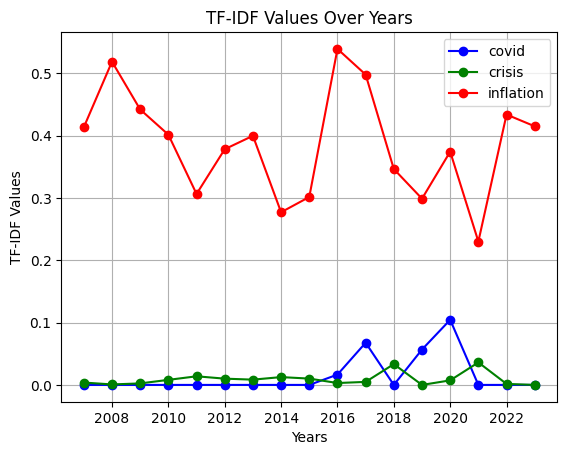

In [72]:
import matplotlib.pyplot as plt

# Extract years and tfidf values for each dataset
years1, tfidf_values1 = zip(*merged_list_covid)
years2, tfidf_values2 = zip(*merged_list_crisis)
years3, tfidf_values3 = zip(*merged_list_inf)

# Convert years to integers for proper ordering on the x-axis
years1 = sorted([int(year) for year in years1])
years2 = [int(year) for year in years2]
years3 = [int(year) for year in years3]

years1.sort()
years2.sort()
years3.sort()


plt.plot(years1, tfidf_values1, marker='o', linestyle='-', color='b', label='covid')
plt.plot(years2, tfidf_values2, marker='o', linestyle='-', color='g', label='crisis')
plt.plot(years3, tfidf_values3, marker='o', linestyle='-', color='r', label='inflation')

# Adding labels and title
plt.xlabel('Years')
plt.ylabel('TF-IDF Values')
plt.title('TF-IDF Values Over Years')

# Adding grid
plt.grid(True)
plt.legend()
plt.show()

In [73]:
top_tfidf = tfidf_df.sort_values(by=['document','tfidf'], ascending=[True,False]).groupby(['document']).head(5)

In [14]:
tdidf_1 = tfidf_df.sort_values(by=['document','tfidf'], ascending=[True,False]).groupby(['document'])

In [11]:
top_tfidf[top_tfidf['term'].str.contains('risk')]

,document,term,tfidf
55054,2007,risks,0.122287


In [12]:
top_tfidf[top_tfidf['term'].str.contains('growth')]

,document,term,tfidf
52058,2007,growth,0.346300
92653,2008,growth,0.256168
35820,2010,growth,0.139926
43939,2011,growth,0.141428
68296,2012,growth,0.176273
27701,2014,growth,0.171327
19582,2015,growth,0.150506
3344,2016,growth,0.179316
133248,2018,growth,0.195025
125129,2019,growth,0.202284


In [13]:
# adding a little randomness to break ties in term ranking
top_tfidf_plusRand = top_tfidf.copy()
top_tfidf_plusRand['tfidf'] = top_tfidf_plusRand['tfidf'] + np.random.rand(top_tfidf.shape[0])*0.0001

# base for all visualizations, with rank calculation
base = alt.Chart(top_tfidf_plusRand).encode(
    x = 'rank:O',
    y = 'document:N'
).transform_window(
    rank = "rank()",
    sort = [alt.SortField("tfidf", order="descending")],
    groupby = ["document"],
)

# heatmap specification
heatmap = base.mark_rect().encode(
    color = 'tfidf:Q'
)

# text labels, white for darker heatmap colors
text = base.mark_text(baseline='middle').encode(
    text = 'term:N',
    color = alt.condition(alt.datum.tfidf >= 0.23, alt.value('white'), alt.value('black'))
)

# display the three superimposed visualizations
(heatmap + text).properties(width = 600)

alt.LayerChart(...)

In [18]:
tdidf_1[top_tfidf['term'].str.contains('inflation')]

KeyError: 'Columns not found: False, True'